In [1]:
!pip install tensorflow==2.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tens

In [1]:
import pandas as pd
from tensorflow import keras
import sklearn.metrics as metrics
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, LSTM, Bidirectional
from keras.utils import to_categorical
import joblib
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
!python --version

Python 3.10.12


In [ ]:
print(np.__version__)
print(keras.__version__)
print(joblib.__version__)

1.25.2
2.9.0
1.4.2


In [3]:
# Returns X_train, X_test, y_train, y_test that works with model
def get_training_data(X, y, labels):
  labels_map = {k: v for v, k in enumerate(labels)}
  y_num = np.zeros_like(y, dtype=float)
  for i in range(y_num.shape[0]):
    y_num[i] = labels_map[y[i]]
  y_num = to_categorical(y_num, num_classes=len(labels))
  return train_test_split(X, y_num, test_size=0.2, random_state=30)

In [4]:
# Takes in training and testing data, outputs tokenized and padded
def standardize_data(X_train, X_test, word_count):
  tokenizer = Tokenizer(num_words=word_count, oov_token="<OOV>")
  tokenizer.fit_on_texts(X_train)
  X_train_seq = tokenizer.texts_to_sequences(X_train)
  X_test_seq = tokenizer.texts_to_sequences(X_test)

  filename = 'tokenizer_' + str(word_count) + '.joblib'
  #joblib.dump(tokenizer, filename)

  # loading
  #joblib.load(path)

  max_length = max(len(x) for x in X_train_seq)
  print(max_length)
  X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
  X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

  return X_train_padded, X_test_padded, max_length

In [5]:
# Loading the data

df = pd.read_csv('final intensity data.csv')
df.dropna(subset=['Intensity'], inplace=True)
df.dropna(subset=['Classification'], inplace=True)
print(df)

# Load intensity data
# intensity_df = pd.read_csv('/content/Intensity Database - Attempt 2.csv')
# intensity_df.dropna(subset=['Intensity'], inplace=True)
# intensity_df.dropna(subset=['Classification'], inplace=True)
# intensity_df

                                                  Query Classification  \
0     I am interested in art and want to learn more ...           Arts   
1     I like drawing in my leisure time, is there a ...           Arts   
2     I recently downloaded an editing software and ...           Arts   
3            I recently wanted to get into breakdancing           Arts   
4     I want to get out of my comfort zone by joinin...           Arts   
...                                                 ...            ...   
1354  Exploring bioinformatics research labs and stu...           STEM   
1355  Passionate about technology's role in public h...           STEM   
1356  Eager to join a medical innovation club focuse...           STEM   
1357  Actively seeking ethical hacking opportunities...           STEM   
1358  Experienced transfer student interested in imp...           STEM   

      Intensity  
0             1  
1             1  
2             1  
3             1  
4             1  
...

In [12]:
# Experimenting with the priority model
dict_word_count = 10000

# Getting relevant data
queries = df['Query'].values
intensity = df['Intensity'].values
intensity_labels = [1, 2, 3]

# Morphing data to form into model
X_train, X_test, y_train_intensity, y_test_intensity = get_training_data(queries, intensity, intensity_labels)
X_train_padded, X_test_padded, max_length = standardize_data(X_train, X_test, dict_word_count)

# Create model
intensity_model = Sequential([
    Embedding(input_dim=dict_word_count, output_dim=16,input_length=max_length),
    #LSTM(units=2, dropout=0.5, return_sequences=True),
    LSTM(units=10, dropout=0.80),
    Dense(3, activation='softmax')
])

intensity_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
intensity_model.summary()

# Fit model and show how it went
history = intensity_model.fit(X_train_padded, y_train_intensity, epochs=30, validation_data=(X_test_padded, y_test_intensity))
test_loss, test_acc = intensity_model.evaluate(X_test_padded, y_test_intensity, verbose=2)

print('\nTest accuracy:', test_acc)

predictions = intensity_model.predict(X_test_padded)
predicted_priorities = np.argmax(predictions, axis=1)

# save model
#intensity_model.save("intensity_model.keras")


31
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 31, 16)            160000    
                                                                 
 lstm_4 (LSTM)               (None, 10)                1080      
                                                                 
 dense_4 (Dense)             (None, 3)                 33        
                                                                 
Total params: 161,113
Trainable params: 161,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
34/34 [==============================] - 8s 55ms/step - loss: 1.0989 - accuracy: 0.3174 - val_loss: 1.0971 - val_accuracy: 0.3493
Epoch 2/30
34/34 [==============================] - 1s 30ms/step - loss: 1.0888 - accuracy: 0.4213 - val_loss: 1.0597 - val_accuracy: 0.5074
Epoch 3/30
34/34 [=========

In [13]:
# Confusion matrix to see whats going on

y_prediction_conf = intensity_model.predict(X_test_padded)
y_prediction_conf = np.argmax(y_prediction_conf, axis=1)
y_test_conf = np.argmax(y_test_intensity, axis=1)
intensity_confusion = metrics.confusion_matrix(y_test_conf, y_prediction_conf, normalize='pred')
print(intensity_confusion)

9/9 [==============================] - 0s 9ms/step
[[0.96629213 0.07407407 0.        ]
 [0.03370787 0.88888889 0.        ]
 [0.         0.03703704 1.        ]]


<Axes: >

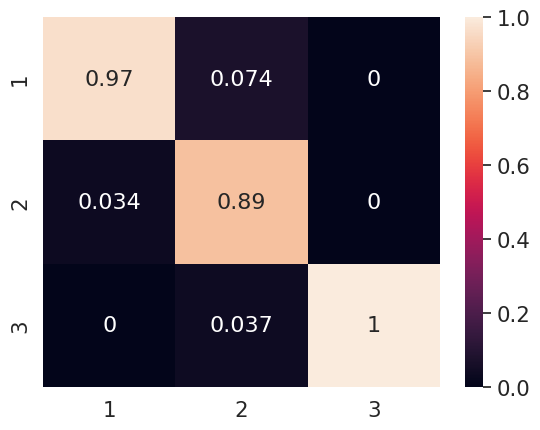

In [16]:
# Plot confusion matrix

df_cm = pd.DataFrame(intensity_confusion, intensity_labels, intensity_labels)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [17]:
# Loading the data

df = pd.read_csv('final data.csv')
df.dropna(subset=['Intensity'], inplace=True)
df.dropna(subset=['Classification'], inplace=True)

In [19]:
# Experimenting with category model
dict_word_count = 10000

# Getting relevant data
queries = df['Query'].values

# Getting needed data
classifications = df['Classification'].values
classification_labels = ["Arts","Athletics","Business","Culture","Government","Professional","Religion","Service","Social","STEM"]

# Morphing data to fit into model
X_train, X_test, y_train_category, y_test_category = get_training_data(queries, classifications, classification_labels)
X_train_padded, X_test_padded, max_length = standardize_data(X_train, X_test, dict_word_count)

# Create model
category_model = Sequential([
    Embedding(input_dim=dict_word_count, output_dim=32,input_length=max_length),
    Bidirectional(LSTM(40,dropout=0.9)),
    Dense(10, activation='softmax')
])

category_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
category_model.summary()

# Fit model and show how it went
history = category_model.fit(X_train_padded, y_train_category, epochs=50, validation_data=(X_test_padded, y_test_category))
test_loss, test_acc = category_model.evaluate(X_test_padded, y_test_category, verbose=2)

print('\nTest accuracy:', test_acc)

predictions = category_model.predict(X_test_padded)
predicted_categories = np.argmax(predictions, axis=1)

#category_model.save("category_model.keras")

35
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 35, 32)            320000    
                                                                 
 bidirectional (Bidirectiona  (None, 80)               23360     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 10)                810       
                                                                 
Total params: 344,170
Trainable params: 344,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
74/74 [==============================] - 11s 94ms/step - loss: 2.2996 - accuracy: 0.1236 - val_loss: 2.2911 - val_accuracy: 0.1487
Epoch 2/50
74/74 [==============================] - 5s 62ms/step - loss: 2.2446 - accuracy: 0.1710 - 

In [ ]:
print(X_train_padded)
print(X_train_padded.shape)

[[ 19   5  32 ...   0   0   0]
 [  9  14   2 ...   0   0   0]
 [ 15   2  52 ...   0   0   0]
 ...
 [ 19   5  58 ...   0   0   0]
 [  8   3 359 ...   0   0   0]
 [ 15   6   3 ...   0   0   0]]
(600, 31)


In [20]:
# Confusion matrix for categories to see whats going on

y_prediction_conf = category_model.predict(X_test_padded)
y_prediction_conf = np.argmax(y_prediction_conf, axis=1)
y_test_conf = np.argmax(y_test_category, axis=1)
category_confusion = metrics.confusion_matrix(y_test_conf, y_prediction_conf, normalize='pred')
print(category_confusion)

19/19 [==============================] - 0s 8ms/step
[[0.87755102 0.         0.         0.         0.         0.
  0.         0.         0.01754386 0.        ]
 [0.02040816 0.98181818 0.         0.         0.         0.
  0.         0.         0.26315789 0.        ]
 [0.         0.         0.85915493 0.         0.         0.
  0.         0.04477612 0.03508772 0.01369863]
 [0.08163265 0.         0.         0.94339623 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.96491228 0.04
  0.         0.01492537 0.         0.02739726]
 [0.         0.         0.12676056 0.         0.         0.92
  0.01886792 0.02985075 0.03508772 0.01369863]
 [0.         0.         0.         0.03773585 0.         0.
  0.8490566  0.         0.01754386 0.02739726]
 [0.         0.         0.         0.         0.01754386 0.
  0.01886792 0.89552239 0.         0.01369863]
 [0.02040816 0.01818182 0.         0.01886792 0.01754386 0.04
  0.03773585 0.01492537 0

<Axes: >

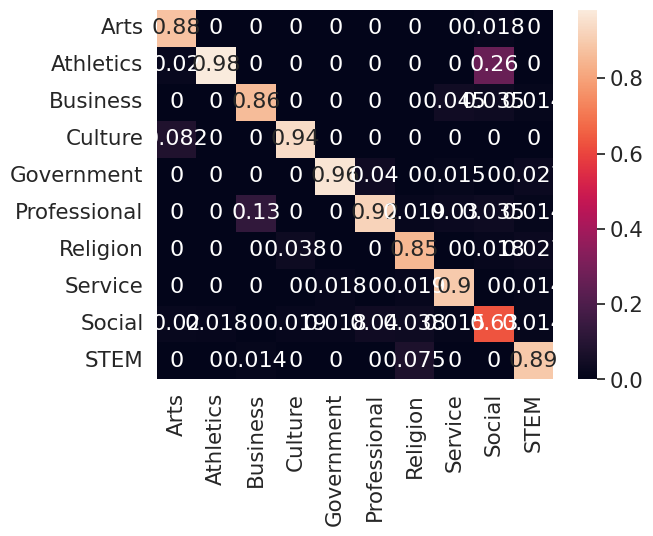

In [21]:
# Plot Confusion matrix

# Plot confusion matrix

df_cm = pd.DataFrame(category_confusion, classification_labels, classification_labels)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [ ]:
# Testing loading and using the models

max_length = 35
intensity_tokenizer = joblib.load('tokenizer_2500.joblib')
loaded_intensity_model = keras.models.load_model("intensity_model.keras")
category_tokenizer = joblib.load('tokenizer_10000.joblib')
loaded_category_model = keras.models.load_model("category_model.keras")

# get query
query = "I want to play some basket and soccer for fun, low commitment"
# intensity: tokensize and pad query
query_seq = intensity_tokenizer.texts_to_sequences([query])
query_padded = pad_sequences(query_seq, maxlen=max_length, padding='post')
# intensity: get prediction
intensity_prediction = intensity_model.predict(query_padded)
# category: tokensize and pad query
query_seq = category_tokenizer.texts_to_sequences([query])
query_padded = pad_sequences(query_seq, maxlen=max_length, padding='post')
# cateogry: get prediction
category_prediction = category_model.predict(query_padded)

1/1 [==============================] - 0s 39ms/step


In [ ]:
print(intensity_prediction)
print(category_prediction)

print(intensity_labels[np.argmax(intensity_prediction)])
print(classification_labels[np.argmax(category_prediction)])

[[0.46818143 0.4264311  0.10538749]]
[[1.59279990e-03 6.15818858e-01 5.53428035e-05 2.87453859e-05
  1.20340796e-04 9.29758389e-05 1.34425126e-02 2.38510314e-03
  3.66401494e-01 6.18156482e-05]]
1
Athletics
